In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline 
pd.set_option('display.max_columns', 100)

In [2]:
subscriber = pd.read_csv('subscribers.csv')
engagement = pd.read_pickle('engagement')
channel_df = pd.read_csv('channel_spend_graduate.csv')

## 1. Atttribution and allocation 

In [3]:
channel_df.describe()

,date,spend_AED
count,40.000000,40.000000
mean,201932.500000,8897.400000
std,40.373258,12161.404319
min,201907.000000,12.000000
25%,201908.750000,143.500000
50%,201910.500000,1700.000000
75%,201934.250000,14500.000000
max,202002.000000,44000.000000


In [4]:
attribution_df = subscriber[['subid','attribution_technical',
                             'account_creation_date','monthly_price','discount_price']]

attribution_df['account_creation_month'] = attribution_df['account_creation_date'].\
                                                apply(lambda x:int(x[:7].replace('-','')))
attribution_df = attribution_df[attribution_df['account_creation_month']>=201907]
attribution_df = attribution_df[attribution_df['account_creation_month']<=202002]
attribution_df = attribution_df.reset_index(drop=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### 1a. Total Average CAC

In [5]:
total_channel_df=channel_df.groupby(['channel']).sum()[['spend_AED']].reset_index()
total_channel_df

,channel,spend_AED
0,bing,10800
1,display,366
2,facebook,113500
3,search,222500
4,youtube,8730


In [6]:
attribution_df.groupby(['attribution_technical']).count()

,subid,account_creation_date,monthly_price,discount_price,account_creation_month
attribution_technical,,,,,
affiliate,8195,8195,8195,8195,8195
appstore,26,26,26,26,26
bing,967,967,967,967,967
bing_organic,271,271,271,271,271
brand sem intent bing,1863,1863,1863,1863,1863
brand sem intent google,16562,16562,16562,16562,16562
content_greatist,4,4,4,4,4
criteo,44,44,44,44,44
direct_mail,137,137,137,137,137


In [7]:
def fix_channel(txt):
    if 'organic' in txt:
        return None
    elif 'bing' in txt:
        return 'bing'
    elif 'facebook' in txt:
        return 'facebook'
    elif 'youtube' in txt:
        return 'youtube'
    elif 'display' in txt or 'criteo' in txt:
        return 'display'
    elif 'google' in txt or 'search' in txt:
        return 'search'
    else:
        return None

attribution_df['channel'] = attribution_df['attribution_technical'].apply(fix_channel)

In [8]:
attribution_df.groupby('subid').count()[['channel']].sort_values(by='channel',ascending=False)

,channel
subid,
20000009,1
25761101,1
25760184,1
25760364,1
25760570,1
...,...
26188714,0
22187227,0
26188666,0


In [9]:
total_user_df = attribution_df.groupby(['channel']).count()[['subid']].reset_index()
total_user_df.columns = ['channel','user_count']

In [10]:
total_avg_df = total_channel_df.merge(total_user_df,on='channel',how='left')

total_avg_df['avg_cac'] = total_avg_df.apply(lambda x: x['spend_AED']/x['user_count'],axis=1)
total_avg_df

,channel,spend_AED,user_count,avg_cac
0,bing,10800,2830,3.816254
1,display,366,1303,0.280890
2,facebook,113500,72044,1.575426
3,search,222500,38667,5.754261
4,youtube,8730,734,11.893733


### 1b. Monthly Average CAC

In [11]:
month_channel_df = channel_df.copy()

In [12]:
month_user_df = attribution_df.groupby(['channel','account_creation_month']).count()[['subid']].reset_index()
month_user_df.columns = ['channel','date','user_count']

In [13]:
month_avg_df = month_channel_df.merge(month_user_df,on=['channel','date'],how='left')

month_avg_df['avg_cac'] = month_avg_df.apply(lambda x: x['spend_AED']/x['user_count'],axis=1)
month_avg_df

,channel,date,spend_AED,user_count,avg_cac
0,bing,201907,400,351,1.139601
1,display,201907,12,58,0.206897
2,facebook,201907,9000,10011,0.899011
3,search,201907,13000,3418,3.803394
4,youtube,201907,90,8,11.250000
5,bing,201908,900,229,3.930131
6,display,201908,20,92,0.217391
7,facebook,201908,13000,9855,1.319127
8,search,201908,18500,3834,4.825248
9,youtube,201908,180,15,12.000000


In [14]:
month_avg_df.to_csv('month_avg_df.csv',index=False)

### 1c. Monthly Average CLV

In [15]:
month_price_df = attribution_df.groupby(['channel','account_creation_month'])\
                .sum()[['discount_price']].reset_index()
month_price_df.columns = ['channel','date','revenue']

In [16]:
month_price_df

,channel,date,revenue
0,bing,201907,1584.4491
1,bing,201908,1033.2885
2,bing,201909,920.8764
3,bing,201910,975.0456
4,bing,201911,1618.1030
5,bing,201912,695.1714
6,bing,202001,2401.5012
7,bing,202002,3548.0826
8,display,201907,261.8178
9,display,201908,415.2972


In [17]:
month_avg_df2 = month_avg_df.merge(month_price_df,on=['channel','date'],how='left')

month_avg_df2['avg_clv'] = month_avg_df2.apply(lambda x: x['revenue']/x['user_count'],axis=1)

month_avg_df2['diff'] = month_avg_df2.apply(lambda x: x['avg_clv']-x['avg_cac'],axis=1)
month_avg_df2

,channel,date,spend_AED,user_count,avg_cac,revenue,avg_clv,diff
0,bing,201907,400,351,1.139601,1584.4491,4.514100,3.374499
1,display,201907,12,58,0.206897,261.8178,4.514100,4.307203
2,facebook,201907,9000,10011,0.899011,45189.9211,4.514027,3.615016
3,search,201907,13000,3418,3.803394,15429.1938,4.514100,0.710706
4,youtube,201907,90,8,11.250000,36.1128,4.514100,-6.735900
5,bing,201908,900,229,3.930131,1033.2885,4.512177,0.582046
6,display,201908,20,92,0.217391,415.2972,4.514100,4.296709
7,facebook,201908,13000,9855,1.319127,44486.4555,4.514100,3.194973
8,search,201908,18500,3834,4.825248,17306.4722,4.513947,-0.311301
9,youtube,201908,180,15,12.000000,67.7115,4.514100,-7.485900


In [18]:
month_avg_df2.to_csv('month_avg_df2.csv',index=False)

## 2 Consumer segementation

In [19]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2585724 entries, 1 to 28832323
Data columns (total 9 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   subid                            int64         
 1   date                             datetime64[ns]
 2   app_opens                        float64       
 3   cust_service_mssgs               float64       
 4   num_videos_completed             float64       
 5   num_videos_more_than_30_seconds  float64       
 6   num_videos_rated                 float64       
 7   num_series_started               float64       
 8   payment_period                   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 197.3 MB


In [20]:
engagement2 = engagement.groupby('subid').mean().reset_index()

In [21]:
engagement2 = engagement2.drop('payment_period', axis=1)

In [22]:
user_df = subscriber.merge(engagement2,on='subid',how='left')

In [23]:
user_df.head(5).T

,0,1,2,3,4
Unnamed: 0,162502,380374,496617,356799,681701
subid,21724479,23383224,26844789,29417030,26723159
package_type,economy,base,enhanced,base,base
num_weekly_services_utilized,NaN,NaN,3.0,NaN,4.0
preferred_genre,comedy,comedy,regional,drama,comedy
intended_use,access to exclusive content,access to exclusive content,replace OTT,replace OTT,replace OTT
weekly_consumption_hour,NaN,22.951579,36.001186,20.051667,22.951579
num_ideal_streaming_services,NaN,NaN,2.0,NaN,3.0
age,NaN,70.0,25.0,30.0,28.0
male_TF,False,False,True,False,False


In [24]:
# split subscribers according to cancel status
user_df['cancel_status'] = user_df['cancel_date'].apply(lambda x: 0 if x is np.nan else 1)
leave_df = user_df[user_df['cancel_status']==1]
stay_df = user_df[user_df['cancel_status']==0]

### 2.a Data preprocessing 

In [25]:
# filter out the feature of consumsers' characteristics
drop_list= ['Unnamed: 0','account_creation_date','trial_end_date','last_payment',
            'next_payment','cancel_date','payment_type','join_fee','months_per_bill_period',
            'num_weekly_services_utilized','num_ideal_streaming_services','num_trial_days','cancel_status',
            'country','attribution_technical','language']
stay_df2 = stay_df.drop(drop_list, axis=1)

stay_df2 = stay_df2[(stay_df2['age']>=10)&(stay_df2['age']<100)]
stay_df2 = stay_df2[stay_df2['weekly_consumption_hour']>=0]

# fill NAs of engagement data with 0
for col in engagement2.columns[1:]:
    stay_df2[col] = stay_df2[col].fillna(0)

# drop NA
stay_df2 = stay_df2.dropna().reset_index(drop=True)

# convert the bool type variables
stay_df2['initial_credit_card_declined_status'] = stay_df2['initial_credit_card_declined']\
.apply(lambda x: 1 if x is True else 0)
stay_df2['current_sub_status'] = stay_df2['current_sub_TF'].apply(lambda x: 1 if x is True else 0)
stay_df2['gender'] = stay_df2['male_TF'].apply(lambda x: 1 if x is True else 0)
stay_df3 = stay_df2.drop(['initial_credit_card_declined','current_sub_TF',
                          'trial_completed','male_TF'],axis = 1)

In [26]:
# stay_df3.to_csv('stay_df3.csv',index=False)

In [27]:
# convert object type variables into dummies
stay_df3 = pd.get_dummies(stay_df3,prefix='package_type',prefix_sep='_',columns=['package_type'])
stay_df3 = pd.get_dummies(stay_df3,prefix='preferred_genre',prefix_sep='_',columns=['preferred_genre'])
stay_df3 = pd.get_dummies(stay_df3,prefix='intended_use',prefix_sep='_',columns=['intended_use'])
stay_df3 = pd.get_dummies(stay_df3,prefix='attribution_survey',prefix_sep='_',
                          columns=['attribution_survey'])
stay_df3 = pd.get_dummies(stay_df3,prefix='op_sys',prefix_sep='_',columns=['op_sys'])
stay_df3 = pd.get_dummies(stay_df3,prefix='plan_type',prefix_sep='_',columns=['plan_type'])

In [28]:
stay_df3.describe()

,subid,weekly_consumption_hour,age,monthly_price,discount_price,payment_period,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,initial_credit_card_declined_status,current_sub_status,gender,package_type_base,package_type_economy,package_type_enhanced,preferred_genre_comedy,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,attribution_survey_affiliate,attribution_survey_amfm_radio,attribution_survey_direct_mail,attribution_survey_facebook,attribution_survey_facebook_organic,attribution_survey_other,attribution_survey_ott,attribution_survey_pinterest,attribution_survey_podcast,attribution_survey_public_radio,attribution_survey_referral,attribution_survey_search,attribution_survey_sirius xm,attribution_survey_social_organic,attribution_survey_tv,attribution_survey_youtube,op_sys_Android,op_sys_iOS,plan_type_base_eur_14_day_trial,plan_type_base_uae_14_day_trial,plan_type_high_aud_14_day_trial,plan_type_high_sar_14_day_trial,plan_type_high_uae_14_day_trial,plan_type_low_gbp_14_day_trial
count,1.243220e+05,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000
mean,2.499326e+07,28.175846,44.936947,4.734965,4.515041,0.936174,1.082666,0.430532,1.517407,2.882746,0.008017,0.258500,0.046597,0.741172,0.134192,0.553072,0.087217,0.359711,0.654590,0.234584,0.035336,0.022104,0.053386,0.475346,0.000282,0.000812,0.000885,0.030767,0.333650,0.158258,0.010481,0.002236,0.002115,0.464688,0.005076,0.035360,0.010497,0.042261,0.020238,0.034499,0.108983,0.049324,0.007199,0.022249,0.164846,0.019948,0.350638,0.649362,0.000056,0.997941,0.000016,0.000032,0.001922,0.000032
std,2.879854e+06,4.916664,13.773598,0.016624,0.022958,0.733714,1.486616,0.623907,1.777032,2.553550,0.048638,0.350897,0.210774,0.437993,0.340860,0.497177,0.282154,0.479918,0.475504,0.423740,0.184628,0.147022,0.224802,0.499394,0.016776,0.028491,0.029733,0.172686,0.471518,0.364985,0.101839,0.047235,0.045946,0.498754,0.071062,0.184688,0.101916,0.201185,0.140813,0.182508,0.311619,0.216544,0.084542,0.147492,0.371043,0.139823,0.477172,0.477172,0.007504,0.045332,0.004011,0.005672,0.043804,0.005672
min,2.000001e+07,2.652191,16.000000,4.000300,3.780100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.250482e+07,24.401536,34.000000,4.734300,4.514100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [29]:
len(stay_df3.columns)

54

In [30]:
# scale the dataset
stay_normalized = preprocessing.normalize(stay_df3, norm='max',axis=0)

stay_df3_norm = pd.DataFrame(stay_normalized)
stay_df3_norm.columns = stay_df3.columns

stay_df3_norm = stay_df3_norm.drop('subid', axis=1)

In [31]:
stay_df3_norm.describe()

,weekly_consumption_hour,age,monthly_price,discount_price,payment_period,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,initial_credit_card_declined_status,current_sub_status,gender,package_type_base,package_type_economy,package_type_enhanced,preferred_genre_comedy,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,attribution_survey_affiliate,attribution_survey_amfm_radio,attribution_survey_direct_mail,attribution_survey_facebook,attribution_survey_facebook_organic,attribution_survey_other,attribution_survey_ott,attribution_survey_pinterest,attribution_survey_podcast,attribution_survey_public_radio,attribution_survey_referral,attribution_survey_search,attribution_survey_sirius xm,attribution_survey_social_organic,attribution_survey_tv,attribution_survey_youtube,op_sys_Android,op_sys_iOS,plan_type_base_eur_14_day_trial,plan_type_base_uae_14_day_trial,plan_type_high_aud_14_day_trial,plan_type_high_sar_14_day_trial,plan_type_high_uae_14_day_trial,plan_type_low_gbp_14_day_trial
count,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000,124322.000000
mean,0.367831,0.493813,0.928188,0.897997,0.312058,0.023926,0.033118,0.116724,0.192183,0.002881,0.129250,0.046597,0.741172,0.134192,0.553072,0.087217,0.359711,0.654590,0.234584,0.035336,0.022104,0.053386,0.475346,0.000282,0.000812,0.000885,0.030767,0.333650,0.158258,0.010481,0.002236,0.002115,0.464688,0.005076,0.035360,0.010497,0.042261,0.020238,0.034499,0.108983,0.049324,0.007199,0.022249,0.164846,0.019948,0.350638,0.649362,0.000056,0.997941,0.000016,0.000032,0.001922,0.000032
std,0.064186,0.151358,0.003259,0.004566,0.244571,0.032853,0.047993,0.136695,0.170237,0.017479,0.175448,0.210774,0.437993,0.340860,0.497177,0.282154,0.479918,0.475504,0.423740,0.184628,0.147022,0.224802,0.499394,0.016776,0.028491,0.029733,0.172686,0.471518,0.364985,0.101839,0.047235,0.045946,0.498754,0.071062,0.184688,0.101916,0.201185,0.140813,0.182508,0.311619,0.216544,0.084542,0.147492,0.371043,0.139823,0.477172,0.477172,0.007504,0.045332,0.004011,0.005672,0.043804,0.005672
min,0.034624,0.175824,0.784173,0.751825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.318558,0.373626,0.928058,0.897810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0

### 2.b Clustering 

In [32]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=68)
    kmeans.fit(stay_df3_norm)
    sse[k] = kmeans.inertia_ 

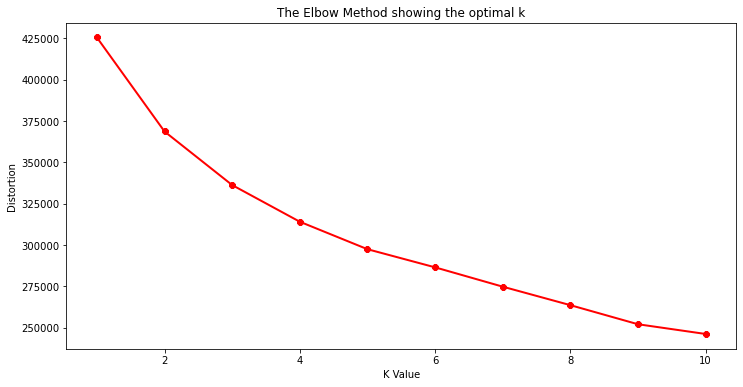

In [33]:
plt.figure(figsize=(12,6))
plt.plot(list(sse.keys()),list(sse.values()),linewidth=2, color="red", marker ="8")
plt.xlabel('K Value')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [34]:
kmeans=KMeans(n_clusters=3, random_state = 68).fit(stay_df3_norm)
y_kmeans=kmeans.predict(stay_df3_norm)

y_result=pd.DataFrame(y_kmeans)


In [35]:
stay_df3['cluster']=y_result[0]

In [36]:
stay_df3['cluster'].value_counts()

0    50324
2    44720
1    29278
Name: cluster, dtype: int64

In [37]:
stay_df3.groupby('cluster').mean()

,subid,weekly_consumption_hour,age,monthly_price,discount_price,payment_period,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,initial_credit_card_declined_status,current_sub_status,gender,package_type_base,package_type_economy,package_type_enhanced,preferred_genre_comedy,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,attribution_survey_affiliate,attribution_survey_amfm_radio,attribution_survey_direct_mail,attribution_survey_facebook,attribution_survey_facebook_organic,attribution_survey_other,attribution_survey_ott,attribution_survey_pinterest,attribution_survey_podcast,attribution_survey_public_radio,attribution_survey_referral,attribution_survey_search,attribution_survey_sirius xm,attribution_survey_social_organic,attribution_survey_tv,attribution_survey_youtube,op_sys_Android,op_sys_iOS,plan_type_base_eur_14_day_trial,plan_type_base_uae_14_day_trial,plan_type_high_aud_14_day_trial,plan_type_high_sar_14_day_trial,plan_type_high_uae_14_day_trial,plan_type_low_gbp_14_day_trial
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.501081e+07,28.107854,46.610015,4.734988,4.515064,0.870777,1.418055,0.453796,1.523184,2.915413,0.006601,0.267039,0.037358,0.698692,0.128865,0.868075,0.131925,0.0,0.637270,0.254093,0.034755,0.022653,0.051228,0.508704,0.000258,0.000755,0.000994,0.029449,0.311025,0.148816,0.011446,0.002643,0.002722,0.457376,0.005385,0.033066,0.010134,0.042246,0.023865,0.040080,0.120042,0.040637,0.007948,0.023289,0.162288,0.016831,0.000000,1.000000,0.000040,0.997973,0.000000,0.000020,0.001928,0.000040
1,2.499372e+07,28.018507,46.847643,4.734989,4.515078,0.894494,0.530920,0.372821,1.554196,2.866122,0.013731,0.263799,0.052702,0.705000,0.130952,0.856411,0.143589,0.0,0.610458,0.281542,0.045802,0.023567,0.038630,0.521006,0.000376,0.000956,0.001059,0.033745,0.284104,0.158754,0.009188,0.002527,0.001674,0.466255,0.003723,0.036136,0.009666,0.041260,0.012569,0.035385,0.096865,0.044504,0.006285,0.017829,0.193900,0.022235,1.000000,0.000000,0.000000,0.997951,0.000034,0.000034,0.001981,0.000000
2,2.497321e+07,28.355367,41.803297,4.734924,4.514990,1.037053,1.066473,0.442134,1.486821,2.856868,0.005870,0.245423,0.052996,0.812657,0.142308,0.000000,0.000000,1.0,0.702974,0.181887,0.029137,0.020528,0.065474,0.407916,0.000246,0.000783,0.000648,0.030300,0.391547,0.168560,0.010242,0.001588,0.001722,0.471892,0.005613,0.037433,0.011449,0.042934,0.021176,0.027639,0.104472,0.062254,0.006954,0.023971,0.148703,0.021959,0.320081,0.679919,0.000112,0.997898,0.000022,0.000045,0.001878,0.000045


In [38]:
cluster_mean = stay_df3.groupby('cluster').mean()
cluster_mean.to_csv('cluster_mean.csv',index=False)

In [39]:
stay_df3.to_csv('stay_df3_with_cluster.csv',index=False)

In [40]:
# stay_df[stay_df['package_type'].isnull()]

#### Using RFM Features

In [41]:
stay_df4_norm = stay_df3_norm[['weekly_consumption_hour','discount_price','payment_period',\
               'app_opens','num_videos_completed','num_videos_more_than_30_seconds','num_videos_rated','num_series_started']]

In [42]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=68)
    kmeans.fit(stay_df4_norm)
    sse[k] = kmeans.inertia_ 

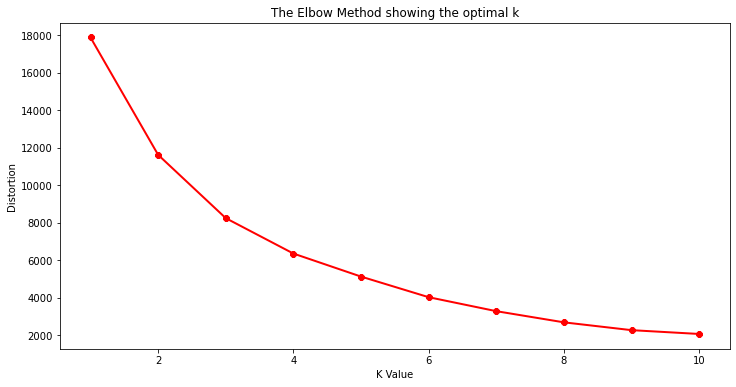

In [43]:
plt.figure(figsize=(12,6))
plt.plot(list(sse.keys()),list(sse.values()),linewidth=2, color="red", marker ="8")
plt.xlabel('K Value')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [44]:
kmeans=KMeans(n_clusters=3, random_state = 68).fit(stay_df4_norm)
y_kmeans=kmeans.predict(stay_df4_norm)

y_result=pd.DataFrame(y_kmeans)
stay_df3['cluster']=y_result[0]
stay_df3['cluster'].value_counts()

1    47952
0    47069
2    29301
Name: cluster, dtype: int64

In [45]:
cluster_mean = stay_df3.groupby('cluster').mean()

cluster_mean.to_csv('cluster_mean_2.csv',index=False)
stay_df3.to_csv('stay_df4_with_cluster.csv',index=False)

## 3 Churn

In [46]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
import copy
import math

In [47]:
df = user_df.copy()

In [48]:
df.describe()

,Unnamed: 0,subid,num_weekly_services_utilized,weekly_consumption_hour,num_ideal_streaming_services,age,months_per_bill_period,monthly_price,discount_price,join_fee,num_trial_days,payment_period,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,cancel_status
count,227628.000000,2.276280e+05,117178.000000,189698.000000,115458.000000,1.924590e+05,227628.0,227628.000000,227628.000000,192724.000000,227628.000000,227628.000000,135019.000000,135019.000000,135019.000000,135019.000000,135019.000000,135019.000000,227628.000000
mean,341129.200041,2.498624e+07,3.008824,27.997724,2.061260,7.579755e+02,4.0,4.732049,4.512188,0.115145,13.989544,0.790122,1.804594,0.639532,2.492495,4.685488,0.021318,0.466251,0.161803
std,197094.201084,2.885543e+06,0.820526,4.976341,0.245907,1.920204e+05,0.0,0.101049,0.097078,0.176971,0.382453,0.777713,1.550107,0.614903,1.599658,1.194731,0.076552,0.364733,0.368271
min,1.000000,2.000001e+07,0.000000,-32.146760,-1.000000,0.000000e+00,4.0,0.807400,0.770700,-0.660600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,170766.250000,2.248998e+07,2.000000,24.401536,2.000000,3.500000e+01,4.0,4.734300,4.514100,0.036700,14.000000,0.000000,1.000000,0.285714,1.117647,4.276923,0.000000,0.000000,0.000000
50%,340985.500000,2.497011e+07,3.000000,27.301448,2.000000,4.600000e+01,4.0,4.734300,4.514100,0.036700,14.000000,1.000000,1.200000,0.486486,2.375000,4.583333,0.000000,0.500000,0.000000
75%,511844.000000,2.749020e+07,3.000000,30.201361,2.000000,5.700000e+01,4.0,4.734300,4.514100,0.110100,14.000000,1.000000,2.166667,0.750000,3.750000,5.285714,0.000000,0.818182,0.000000
max,682885.000000,2.999998e+07,14.000000,76.599962,7.000000,8.172000e+07,4.0,5.101300,5.027900,0.734000,14.000000,3.000000,45.250000,13.000000,13.000000,15.000000,2.782609,2.000000,1.000000


In [49]:
df['cancel_status'] = df.apply(lambda x: \
                               1 if (x['cancel_date'] is not np.nan) or (x['current_sub_TF'] == False) else 0,
                              axis=1)

In [50]:
df['cancel_status'].value_counts()

0    129354
1     98274
Name: cancel_status, dtype: int64

In [51]:
len(df)

227628

In [52]:
# filter out the feature of consumsers' characteristics
drop_list2= ['Unnamed: 0','subid','account_creation_date','trial_end_date','last_payment',
            'next_payment','cancel_date','join_fee','months_per_bill_period','num_trial_days',
            'attribution_technical','language','country','payment_type','num_ideal_streaming_services',
            'plan_type','attribution_survey','current_sub_TF','discount_price']
df2 = df.drop(drop_list2, axis=1)

# fill NAs of engagement data with 0
for col in engagement2.columns[1:]:
    df2[col] = df2[col].fillna(0)

df2['num_weekly_services_utilized'] = df2['num_weekly_services_utilized'].fillna(0)

df2 = df2[(df2['age']>=10)&(df2['age']<100)]
df2 = df2[df2['weekly_consumption_hour']>=0]
df2 = df2[df2['num_weekly_services_utilized']>=0]

# drop NA
df2 = df2.dropna().reset_index(drop=True)

# convert the bool type variables
df2['initial_credit_card_declined_status'] = df2['initial_credit_card_declined']\
.apply(lambda x: 1 if x is True else 0)
df2['trial_completed_status'] = df2['trial_completed'].apply(lambda x: 1 if x is True else 0)
df2['gender'] = df2['male_TF'].apply(lambda x: 1 if x is True else 0)

df2 = df2.drop(['initial_credit_card_declined',
                'trial_completed','male_TF'],axis = 1)

In [53]:
# convert object type variables into dummies
# payment_type
df3 = pd.get_dummies(df2,prefix='package_type',prefix_sep='_',columns=['package_type'],drop_first=True)
df3 = pd.get_dummies(df3,prefix='preferred_genre',prefix_sep='_',columns=['preferred_genre'],drop_first=True)
df3 = pd.get_dummies(df3,prefix='intended_use',prefix_sep='_',columns=['intended_use'],drop_first=True)
df3 = pd.get_dummies(df3,prefix='op_sys',prefix_sep='_',columns=['op_sys'],drop_first=True)

In [54]:
df_train, df_test = model_selection.train_test_split(df3, test_size=0.3,random_state=99)

In [55]:
len(df3.columns)

28

In [56]:
# ----- FIT CHURN MODEL ------
y_col_name = 'cancel_status' # specify which column contains outcome variable y. Needs to be coded as binary True/False or 0/1
x_col_name = list(set(df3.columns)-{'cancel_status'})    # list of x covariates
add_constant_TF = False

In [57]:
# --- preprocess data for model routine format requirements
if add_constant_TF:
    x_col_name.append('const')
    df_train = sm.add_constant(df_train)
    df_test = sm.add_constant(df_test)

In [58]:
# --- fit logistic regression
# logit_model = sm.Logit(endog=np.array(df_train[y_col_name]), exog=np.array(df_train[x_col_name]))
logit_model = sm.Logit(endog=df_train[y_col_name], exog=df_train[x_col_name])
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.195747
         Iterations 15

RESULTS OF LOGIT MODEL FITTING

                           Logit Regression Results                           
Dep. Variable:          cancel_status   No. Observations:               100705
Model:                          Logit   Df Residuals:                   100678
Method:                           MLE   Df Model:                           26
Date:                Tue, 14 Dec 2021   Pseudo R-squ.:                  0.6991
Time:                        12:15:23   Log-Likelihood:                -19713.
converged:                       True   LL-Null:                       -65514.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
num_weekly_ser

In [59]:
df_test['prob_churn_logit'] = logit_results.predict(df_test[x_col_name])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 101, 10)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives

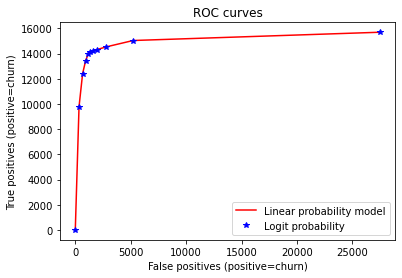

In [61]:
# --- evaluate model predictions using numerical quantification (ROC curves)
# make confusion matrices
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df_test[y_col_name], 
                                                                            df_test['prob_churn_logit'])

# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(logit_false_positives, logit_true_positives, 'r-')
ax1.plot(logit_false_positives, logit_true_positives, 'b*')
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])

In [83]:
list(range(0, 101, 10))

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [63]:
logit_conf_mat[:3]

[array([[    0, 27468],
        [    0, 15692]]),
 array([[22249,  5219],
        [  656, 15036]]),
 array([[24737,  2731],
        [ 1174, 14518]])]

In [64]:
logit_false_positives[:3]

[27468, 5219, 2731]

In [65]:
# best_threshold = 0.2

In [66]:
# ------ DEFINE FUNCTIONS -----
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f[y_col_name] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f[y_col_name] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f[y_col_name] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact

In [67]:
y_col_name

'cancel_status'

In [68]:
df['monthly_price'].value_counts()

4.7343    227101
5.1013       325
1.0643       167
4.4407        18
4.3673        12
4.0003         2
1.1744         1
0.8074         1
4.6976         1
Name: monthly_price, dtype: int64

In [69]:
df['discount_price'].value_counts()

4.5141    227096
5.0279       325
1.0276       167
4.2205        18
4.0737        12
4.3673         4
3.7801         2
4.4407         2
1.1744         1
0.7707         1
Name: discount_price, dtype: int64

In [70]:
round(1-4.5141 / 4.7343,2)

0.05

In [71]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.2
base_price = 4.7343
discount_amount = 1-round(4.5141 / 4.7343,2)
cases = ['no_offer', 'logit_offer']

In [72]:
df_test['random_draws'] = np.random.random(df_test.shape[0])


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, 
                                  acceptance_rate_churn, acceptance_rate_nonchurn)


In [74]:
df_impact


,subs,revenue,lift_from_no_offer
no_offer,27468,130041.7524,0.0
logit_offer,31820,148968.773655,0.145546


In [75]:
# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    acceptance_rate_churn = t_discount_amount
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']

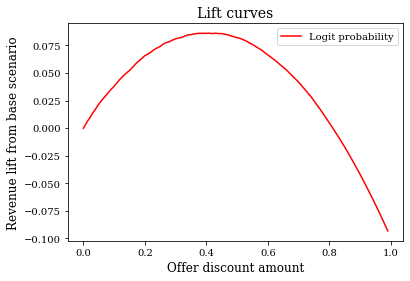

In [76]:
# Discount amount sensitivity
import matplotlib
matplotlib.rcParams['font.family'] = ['serif']

fig = plt.figure()
plt.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves',fontsize=14)
plt.xlabel('Offer discount amount',fontsize=12)
plt.ylabel('Revenue lift from base scenario',fontsize=12)
plt.legend(labels=['Logit probability'])
plt.show()

In [77]:
max_lift = df_lift_discount_amount['logit_offer'].max()
max_discount = df_lift_discount_amount[df_lift_discount_amount['logit_offer']==max_lift]\
                ['discount_amount'].iloc[0]
print("Best discount: ",max_discount)
print("Max lift: ",max_lift)

Best discount:  0.41
Max lift:  0.08607252075141969


In [84]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.2
base_price = 4.7343
discount_amount = 1-round(4.5141 / 4.7343,2)
cases = ['no_offer', 'logit_offer']

In [85]:
df_test['cancel_status'].value_counts()

0    27468
1    15692
Name: cancel_status, dtype: int64

In [86]:
15692/len(df_test)

0.3635773864689527

In [87]:
#set
threshold = 0.2
base_num = 10000
# df_test['prob_churn_logit'] = logit_results.predict(df_test[x_col_name])
# aa = df_test[df_test['prob_churn_logit']>threshold].shape[0]
model_churn_r = 15692/len(df_test)

print('churn rate:',model_churn_r)
model_churn_num = round(base_num*model_churn_r)
model_not_churn = base_num-model_churn_num


#看不同discount和不同offer人群对应的revenue
for discount in [max_discount]:
    print('discount = acceptance rate:',discount)
    accept_rate = discount
    
    #不给offer
    no_discount_revenue = model_not_churn*base_price
    print('Total revenue without discount offer:：',no_discount_revenue)

    #给所有人offer
    churn_revenue = model_churn_num*accept_rate*(1-discount)*base_price
    not_churn_revenue = model_not_churn*base_price*(1-discount)
    all_churn_revenue = churn_revenue + not_churn_revenue
    print('Total revenue with discount offer to all：',all_churn_revenue)
    lift1 = all_churn_revenue/no_discount_revenue
    print('Total lift with discount offer to all：',lift1)

    #只给churn offer
    only_churn_revenue = churn_revenue+no_discount_revenue
    lift2 = only_churn_revenue/no_discount_revenue
    print('Total revenue with discount offer to chrun people:',only_churn_revenue)
    print('Total lift with discount offer to chrun people：',lift2)
    
    print(' ')

churn rate: 0.3635773864689527
discount = acceptance rate: 0.41
Total revenue without discount offer:： 30129.0852
Total revenue with discount offer to all： 21940.206258120004
Total lift with discount offer to all： 0.7282068510370837
Total revenue with discount offer to chrun people: 34293.13119012
Total lift with discount offer to chrun people： 1.1382068510370835
 
